# Part 0: Data Loading

In [1]:
# Install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile({'id':'1FEZ0Gv7KAszXPN36PQ6y7Q7rRBccL8gG'})
file.GetContentFile('reviews.tsv')

In [2]:
# Load the dataset into a Pandas DataFrame
import numpy as np
import pandas as pd

df = pd.read_csv('reviews.tsv', sep='\t', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkip

# Part 1: View Dataset Content

In [3]:
# See the first few observations in the dataset
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [4]:
# Drop missing value (rows without an review)
df.dropna(subset=['review_body'],inplace=True)
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960056 entries, 0 to 960055
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [5]:
# Store the review column of the dataset into a list
reviews = df['review_body'].tolist()
# See the first 10 reviews
print('The first 10 reviews:\n')
for i in range(10):
    print('({}) {}'.format(i, reviews[i]))

The first 10 reviews:

(0) Absolutely love this watch! Get compliments almost every time I wear it. Dainty.
(1) I love this watch it keeps time wonderfully.
(2) Scratches
(3) It works well on me. However, I found cheaper prices in other places after making the purchase
(4) Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch
(5) i love this watch for my purpose, about the people complaining should of done their research better before buying. dumb people.
(6) for my wife and she lov

# Part 2: Tokenization and Stemming

In [6]:
import nltk

# Load common stopwords from nltk
# Stopwords will be eliminated from the corpus since they do not carry strong meaning
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
# Add some extra stopwords 
# br: review body sometimes contain html words <br> and </br>
# watch: the word that frequently appears in watch-review documents and is useless for sentiment analysis
additional_stopwords = ['\'s', '\'m', 'br', 'watch']
stopwords.extend(additional_stopwords)
print('{} stopwords in total.'.format(len(stopwords)))
print('First 10 stopwords:\n{}'.format(stopwords[:10]))
stopwords = set(stopwords)

183 stopwords in total.
First 10 stopwords:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

'''
This functions takes a sentence (text) as input and tokenize it first.
The sentence will be broken into individual lowercase tokens/words, 
with stopwords and non-alphabetic words removed.
Stemming is then performed to break down each word to its root form.
A list of processed words will be the final output.
'''
def preprocessing(text):
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word.lower() not in stopwords and word.isalpha()]
    return [stemmer.stem(t) for t in tokens]

In [8]:
# See the transformation of the first review as an example
nltk.download('punkt')
print('Original Review:\n{}\n'.format(reviews[0]))
print('Stems:\n{}'.format(preprocessing(reviews[0])))

Original Review:
Absolutely love this watch! Get compliments almost every time I wear it. Dainty.

Stems:
['absolut', 'love', 'get', 'compliment', 'almost', 'everi', 'time', 'wear', 'dainti']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 3: TF-IDF

Calculate the TF-IDF matrix of the corpus. The TF-IDF value of each word-doc pair reflect the importance of the word in that document (review).

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Construct the model
model_tfidf = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words='english',
    max_df=0.99,
    min_df=0.01,
    max_features=1000
)
tfidf_matrix = model_tfidf.fit_transform(reviews)
print('TF-IDF matrix shape: {} reviews x {} words'.format(*tfidf_matrix.shape))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  % sorted(inconsistent)


TF-IDF matrix shape: 960056 reviews x 353 words


In [10]:
# Save the words selected by the TF-IDF model
important_words = model_tfidf.get_feature_names_out()
print('Number of selected words: {}'.format(len(important_words)))
print('First 10 selected words:\n{}'.format(important_words[:10]))

Number of selected words: 353
First 10 selected words:
['abl' 'absolut' 'accur' 'actual' 'adjust' 'ago' 'alarm' 'alreadi' 'alway'
 'amaz']


# Part 4: K-Means Clustering

### Part 4.1: Find the Optimal Value of K

[Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)): 

For each value of K and the corresponding clustering outcome, calculate the sum of squared distance from each point to its cluster centroid. Save this value as the inertia for this K. The point where this inertia value declines the most as K increases is the elbow point, and this K is regarded as optimal.

[Kneedle Algorithm](https://raghavan.usc.edu/papers/kneedle-simplex11.pdf):

An algorithm to find the elbow/knee point.



In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the inertia value for each K to represent the cost
inertia = []
k_values = range(1, 21)
for k in k_values:
    km = KMeans(n_clusters=k, max_iter=500)
    km.fit(tfidf_matrix)
    inertia.append(km.inertia_)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Optimal Value of K = 9



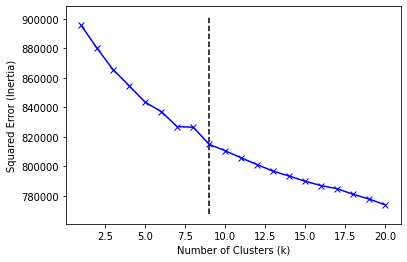

In [12]:
!pip install kneed

from kneed import KneeLocator

# Use Kneedle algorithm to calculate the best K
kn = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
optimal_k = kn.knee
print('\nOptimal Value of K = {}\n'.format(optimal_k))

# Plot the cost against K values and mark the optimal K
plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Squared Error (Inertia)')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

### Part 4.2: Model Training

In [13]:
# Initialize and train the K-means model
model_km = KMeans(n_clusters=optimal_k)
model_km.fit(tfidf_matrix)
# Use a list to save the cluster each review is grouped into
clusters = model_km.labels_.tolist()

### Part 4.3: Result Analysis

In [14]:
# Store each review and the corresponding cluster number into a DataFrame
review_cluster = pd.DataFrame({'review': df.review_body, 'cluster': clusters}, columns=['review', 'cluster'])
review_cluster.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,1
1,I love this watch it keeps time wonderfully.,3
2,Scratches,1
3,"It works well on me. However, I found cheaper ...",1
4,Beautiful watch face. The band looks nice all...,0
5,"i love this watch for my purpose, about the pe...",1
6,"for my wife and she loved it, looks great and ...",2
7,I was about to buy this thinking it was a Swis...,1
8,Watch is perfect. Rugged with the metal &#34;B...,2
9,Great quality and build.<br />The motors are r...,2


In [15]:
print('Number of reviews in each cluster:')
review_cluster['cluster'].value_counts().to_frame()

Number of reviews in each cluster:


,cluster
1,422449
6,183228
0,92339
2,80964
5,44364
3,43790
7,39328
4,33511
8,20083


In [16]:
# Check the centroids of the clusters
km.cluster_centers_

array([[0.00411709, 0.0079338 , 0.00429943, ..., 0.00309661, 0.00473946,
        0.01681934],
       [0.00763845, 0.00333047, 0.00857851, ..., 0.00841759, 0.00433821,
        0.05537361],
       [0.00144622, 0.02181357, 0.00449835, ..., 0.01121273, 0.00246978,
        0.00578941],
       ...,
       [0.00994263, 0.0056334 , 0.02347992, ..., 0.01723799, 0.00593647,
        0.03165095],
       [0.00315903, 0.00805116, 0.00406266, ..., 0.01630169, 0.00549843,
        0.0099701 ],
       [0.0020801 , 0.01096481, 0.00288029, ..., 0.02133911, 0.0019237 ,
        0.01426877]])

In [17]:
print('{} clusters * {} words'.format(*model_km.cluster_centers_.shape))

9 clusters * 353 words


In [18]:
# Each row sorts the indices of words in descending order of their importance in this centroid
word_rank = model_km.cluster_centers_.argsort()[:, ::-1] 

'''
This function prints the clustering result of the cluster given by the input index.
The 10 most important words in this cluster and the first 10 reviews in this
cluster are printed out.
'''
def print_cluster_summary(cluster_index):
    keyword_indices = word_rank[cluster_index, :10]
    keywords = [important_words[keyword_index] for keyword_index in keyword_indices]
    cluster_reviews = review_cluster[review_cluster.cluster==cluster_index].review.tolist()
    print('Cluster {} keywords:\n{}'.format(cluster_index, ', '.join(keywords)))
    print('\nCluster {} selected reviews ({} in total):'.format(cluster_index, len(cluster_reviews)))
    for cluster_review in cluster_reviews[:10]:
        print(cluster_review)

In [19]:
print ('K-Means Clustering Result\n')
for cluster_index in range(optimal_k):
    print_cluster_summary(cluster_index)
    print('\n\n')

K-Means Clustering Result

Cluster 0 keywords:
band, wrist, look, like, fit, great, replac, leather, face, time

Cluster 0 selected reviews (92339 in total):
Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch
This watch is a very beautiful time piece. This also could be an alternative choice to a Rolex submariner. It also has the same features as a Rolex submariner but it's not as good as a Rolex watch but darn close.<br /><br />Take good care of this watch if you get one because

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

# Construct LDA model
model_lda = LatentDirichletAllocation(n_components=optimal_k)
# Train the model and get review-topic matrix
review_topic = model_lda.fit_transform(tfidf_matrix)
print('{} reviews x {} topics'.format(*review_topic.shape))
# Get topic-word matrix
topic_word = model_lda.components_
print('{} topics x {} words'.format(*topic_word.shape))

960056 reviews x 9 topics
9 topics x 353 words


In [21]:
# Store review-topic matrix into a DataFrame
topic_names = ['Topic' + str(i) for i in range(model_lda.n_components)]
review_names = ['Review' + str(i) for i in range(len(review_topic))]
df_review_topic = pd.DataFrame(np.round(review_topic, 2), columns=topic_names, index=review_names)
# Append a column of dominant topic to the DataFrame
main_topic = np.argmax(df_review_topic.values, axis=1)
df_review_topic['MainTopic'] = main_topic
df_review_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,MainTopic
Review0,0.03,0.03,0.03,0.03,0.03,0.03,0.74,0.03,0.03,6
Review1,0.04,0.04,0.04,0.66,0.04,0.04,0.04,0.04,0.04,3
Review2,0.06,0.56,0.06,0.06,0.06,0.06,0.06,0.06,0.06,1
Review3,0.74,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Review4,0.02,0.02,0.59,0.02,0.02,0.02,0.02,0.27,0.02,2
Review5,0.04,0.04,0.04,0.04,0.04,0.04,0.68,0.04,0.04,6
Review6,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.72,8
Review7,0.03,0.74,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1
Review8,0.02,0.53,0.02,0.02,0.02,0.02,0.30,0.02,0.02,1
Review9,0.03,0.03,0.03,0.03,0.76,0.03,0.03,0.03,0.03,4


In [22]:
# Count the number of reviews for each topic
df_review_topic['MainTopic'].value_counts().to_frame()

,MainTopic
4,150810
6,120986
7,119105
1,111680
2,110323
5,108602
0,106687
8,75194
3,56669


In [23]:
# Store topic-word matrix into a DataFrame
df_topic_word = pd.DataFrame(topic_word)
# Set column name to the words
df_topic_word.columns = important_words
df_topic_word.index = topic_names
df_topic_word

,abl,absolut,accur,actual,adjust,ago,alarm,alreadi,alway,amaz,...,wo,wonder,wore,work,worn,worri,worth,wrist,wrong,year
Topic0,345.473325,306.788840,128.521943,330.547893,110.702475,47.203066,0.111467,372.153965,351.416314,624.994542,...,119.823525,507.474721,6.950303,2732.858773,55.885827,130.977621,596.607116,86.854751,305.456986,379.015777
Topic1,445.195911,521.705833,1351.835172,1287.887388,1051.479545,459.540453,103.808111,615.154477,866.134830,490.916252,...,598.556447,427.284812,254.108861,1980.633387,1184.117559,574.475543,668.082661,3734.138187,377.769143,2064.574069
Topic2,1346.378946,414.797656,139.967170,780.172714,4313.394243,59.265163,2.706970,307.610367,379.779728,424.140862,...,509.726152,166.173136,183.224162,2233.260025,417.410882,350.777394,547.340146,11372.528171,301.783698,570.232769
Topic3,19.359869,533.138776,6.221316,261.791469,1.027679,0.111156,0.111120,65.871608,171.528878,488.554465,...,32.141386,1456.067482,5.521325,412.668104,80.600692,46.212040,87.976343,449.397312,199.944682,38.303157
Topic4,1487.335815,410.389216,3596.001814,1334.472957,1980.406994,681.433796,5548.696242,567.052918,1773.131454,502.439394,...,868.639635,521.192750,415.967813,7036.405223,807.513047,1203.180083,914.295483,2193.957399,814.483786,4047.699622
Topic5,33.486803,43.763278,231.624484,1450.047160,28.074680,1.845753,0.111148,94.992925,95.623145,490.715803,...,258.191399,20.304509,2.544559,1631.543238,60.180056,142.518474,2524.472921,1000.746890,574.218762,52.153908
Topic6,91.994807,1129.210622,717.568156,169.474307,72.535736,58.515094,0.111122,518.664935,1916.755788,2666.889028,...,213.200842,353.628988,150.340879,4092.736926,1471.829827,263.171621,665.119946,1514.944971,269.668006,888.036683
Topic7,447.514935,137.070837,157.103156,407.785291,114.727992,2775.757584,4.541091,1666.910176,558.240170,69.554564,...,781.609508,141.412942,2293.383145,9871.210583,1025.604013,119.020619,967.034765,473.269441,782.999413,7562.207088
Topic8,42.454170,3053.327447,16.282042,84.303698,0.124839,0.145013,0.111118,2.826474,112.962477,598.296768,...,36.808890,336.768561,0.320962,518.884722,26.261697,12.481004,1051.067430,28.901502,27.136908,817.166128


In [24]:
# Show the keywords of each topic
topics_keywords = []
# For each topic, obtain the word weights
for words_weights in topic_word:
    # Choose the first 15 keywords of the topic with the highest weight
    keyword_indices = words_weights.argsort()[::-1][:15]
    topics_keywords.append(np.array(important_words).take(keyword_indices))
# Store the keywords of each topic into a DataFrame
df_topic_keywords = pd.DataFrame(topics_keywords)
df_topic_keywords.columns = ['Word' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14
Topic0,product,ship,arriv,item,fast,great,good,batteri,came,deliveri,exact,seller,thank,describ,order
Topic1,band,strap,look,face,like,leather,read,watch,dial,easi,time,wear,great,nice,black
Topic2,wrist,band,small,fit,link,big,size,littl,look,remov,larg,like,face,adjust,pin
Topic3,love,color,awesom,ok,gold,look,classi,great,blue,black,white,like,face,silver,big
Topic4,time,set,use,light,work,easi,read,look,day,like,featur,need,hand,great,date
Topic5,nice,look,like,good,cheap,price,qualiti,realli,pictur,better,feel,great,pretti,expect,heavi
Topic6,great,look,perfect,compliment,love,wear,price,recommend,thank,watch,lot,eleg,good,mani,work
Topic7,good,work,year,broke,month,replac,batteri,time,cute,band,week,day,return,bought,stop
Topic8,excel,gift,love,beauti,bought,husband,christma,wife,son,daughter,birthday,great,present,happi,absolut
